In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import timeit
import datetime
import time
import pprint
import itertools
import pickle
import sklearn
import dask
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
import fastparquet
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import h5py
import collections

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Summary of similarity average by year

In [3]:
rs = fastparquet.ParquetFile("DataStore/2018-10/Reg0930/naics_name_all_0930.parq").to_pandas()

# Add year match
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(["patent", "gyear"])
pdf = dict(zip(pdf["patent"], pdf["gyear"]))
rs["op_gyear"] = rs["op"].map(pdf)
rs["gyear_match"] = (rs["tp_gyear"] == rs["op_gyear"])
del(pdf)

In [20]:
rs.columns

Index(['tp', 'op', 'sim_docvecs', 'sim_ldavecs', 'tp_gyear', 'tp_naics_name',
       'tp_primclass', 'tp_inv_msa', 'op_naics_name', 'op_primclass',
       'op_inv_msa', 'inv_msa_match', 'primclass_match', 'norm_sim_ldavecs',
       'norm_sim_docvecs', 'mean_sim_ldavecs_pc_msa_v',
       'mean_sim_docvecs_pc_msa_v', 'mean_sim_docvecs_pc_v',
       'mean_sim_ldavecs_pc_v', 'norm_mean_sim_ldavecs_pc_msa_v',
       'norm_mean_sim_docvecs_pc_msa_v', 'norm_mean_sim_docvecs_pc_v',
       'norm_mean_sim_ldavecs_pc_v', 'year_group', 'common_est_inv',
       'common_pat_inv', 'lawyer_match', 'num_common_cited',
       'norm_num_common_cited', 'tp_pct_common_cited',
       'norm_tp_pct_common_cited', 'common_cited_match', 'mean_sim_docvecs_pc',
       'mean_sim_ldavecs_pc', 'mean_sim_docvecs_pc_msa',
       'mean_sim_ldavecs_pc_msa', 'sd_sim_docvecs_pc', 'sd_sim_ldavecs_pc',
       'sd_sim_docvecs_pc_msa', 'sd_sim_ldavecs_pc_msa',
       'norm_mean_sim_ldavecs_pc', 'norm_mean_sim_docvecs_pc',
   

In [16]:
dm = "sim_docvecs"
cd = {"common_pat_inv": "Inventor Match", "primclass_match": "Primclass Match", "gyear_match": "Year Match"}

# Same NAICS
# Mean
s1 = rs[[dm, "year_group"]].groupby("year_group").mean().rename(columns={"sim_docvecs": "NAICS Match"})
# SD
s2 = rs[[dm, "year_group"]].groupby("year_group").std().rename(columns={"sim_docvecs": "NAICS Match SD"})
s1 = pd.concat([s1, s2], axis=1)

for k in ["gyear_match", "primclass_match", "common_pat_inv",]:
    s2 = rs.loc[(rs[k] == True), [dm, "year_group"]].groupby("year_group").mean()\
    .rename(columns={"sim_docvecs":cd[k]})
    s3 = rs.loc[(rs[k] == True), [dm, "year_group"]].groupby("year_group").std()\
    .rename(columns={"sim_docvecs":cd[k]})
    s3.columns = [c+" SD" for c in s3.columns]
    s1 = pd.concat([s1, s2, s3], axis=1)
    
s1 = s1.reset_index()

s1 = s1.rename(columns={"year_group": "Year Group"})

# Reorder
s1 = s1[["Year Group", "NAICS Match", "NAICS Match SD", "Primclass Match", "Primclass Match SD",
         "Inventor Match", "Inventor Match SD", "Year Match", "Year Match SD"]]
s1.columns = ["Year Group", "NAICS Match", "S.D.", "Primclass Match", "S.D.", "Inventor Match", "S.D.",
        "Year Match", "S.D."]

In [18]:
print(np.round(s1,3).to_latex(index=False, escape=False))

\begin{tabular}{lrrrrrrrr}
\toprule
Year Group &  NAICS Match &   S.D. &  Primclass Match &   S.D. &  Inventor Match &   S.D. &  Year Match &   S.D. \\
\midrule
   1975-85 &        0.126 &  0.137 &            0.187 &  0.145 &           0.301 &  0.148 &       0.126 &  0.138 \\
   1985-95 &        0.124 &  0.135 &            0.186 &  0.145 &           0.320 &  0.163 &       0.124 &  0.135 \\
   1995-05 &        0.129 &  0.134 &            0.196 &  0.147 &           0.312 &  0.158 &       0.129 &  0.134 \\
   2005-15 &        0.141 &  0.136 &            0.200 &  0.146 &           0.310 &  0.170 &       0.141 &  0.136 \\
\bottomrule
\end{tabular}



In [48]:
s2 = s1.set_index("Year Group").T
print(np.round(s2,3).to_latex(index=True, escape=False, column_format="lcccc"))

\begin{tabular}{lcccc}
\toprule
Year Group &  1975-85 &  1985-95 &  1995-05 &  2005-15 \\
\midrule
NAICS Match     &    0.126 &    0.124 &    0.129 &    0.141 \\
S.D.            &    0.137 &    0.135 &    0.134 &    0.136 \\
Primclass Match &    0.187 &    0.186 &    0.196 &    0.200 \\
S.D.            &    0.145 &    0.145 &    0.147 &    0.146 \\
Inventor Match  &    0.301 &    0.320 &    0.312 &    0.310 \\
S.D.            &    0.148 &    0.163 &    0.158 &    0.170 \\
Year Match      &    0.126 &    0.124 &    0.129 &    0.141 \\
S.D.            &    0.138 &    0.135 &    0.134 &    0.136 \\
\bottomrule
\end{tabular}



## Non-patent vs patent citations in Mutual Citing Patents data

- Code to add additional variables from: https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201808Results/Reg0828/2c-AddingControls-0828.ipynb

### Add additional variables

In [2]:
mdc = fastparquet.ParquetFile("DataStore/2018-07-P2/mutual_cited_0716.parq").to_pandas()
mdc["inv_msa_match"] = (mdc["tp_inv_msa"] == mdc["op_inv_msa"])

import math

def sim_bin(x, a):
    try:
        return round(round(x / a) * a, -int(math.floor(math.log10(a))))
    except:
        return np.nan
    
mdc["bin_sim_docvecs"] = mdc["sim_docvecs"].apply(lambda x: sim_bin(x, 0.1))
mdc.loc[mdc["bin_sim_docvecs"] <= -0.1, "bin_sim_docvecs"] = -0.1
mdc.loc[mdc["bin_sim_docvecs"] >= 0.7, "bin_sim_docvecs"] = 0.7


In [40]:
# Account for common inventors
inv = fastparquet.ParquetFile("RawData/Cleaned/patent_inventors_0628.parq").to_pandas(["patent", "inventor_id"])
%time inv = {n: g["inventor_id"].tolist() for n, g in inv.groupby("patent")}

%time num_common_inv = [len(set(inv[tp]).intersection(inv[op])) if (tp in inv.keys()) & (op in inv.keys())\
                      else np.nan for tp, op in zip(mdc["tp"], mdc["op"])]
mdc["num_common_pat_inv"] = num_common_inv
del(num_common_inv)
mdc["common_pat_inv"] = np.nan
mdc.loc[mdc["num_common_pat_inv"] >= 1, "common_pat_inv"] = True
mdc.loc[mdc["num_common_pat_inv"] == 0, "common_pat_inv"] = False
del(inv)

CPU times: user 11min 28s, sys: 1.04 s, total: 11min 29s
Wall time: 11min 30s
CPU times: user 7.55 s, sys: 75.8 ms, total: 7.62 s
Wall time: 7.1 s


In [42]:
# Account for common lawyers
ldf = pd.read_csv("RawData/Cleaned/patent_lawyer.csv")
%time ldf = {n:g["lawyer_id"].tolist() for n,g in ldf[["patent", "lawyer_id"]].groupby("patent")}
%time l_match = (set(ldf.get(tp, [])).intersection(set(ldf.get(op, []))) for tp, op in zip(mdc["tp"], mdc["op"]))
%time mdc["lawyer_match"] = [len(i) for i in l_match]
%time mdc["lawyer_match"] = mdc["lawyer_match"].apply(lambda x: True if x >= 1 else False)
del(ldf)

CPU times: user 24min 30s, sys: 2.29 s, total: 24min 33s
Wall time: 24min 28s
CPU times: user 92.9 ms, sys: 55.2 ms, total: 148 ms
Wall time: 144 ms
CPU times: user 6.34 s, sys: 22.6 ms, total: 6.36 s
Wall time: 6.19 s
CPU times: user 504 ms, sys: 2.12 ms, total: 506 ms
Wall time: 490 ms


In [43]:
fastparquet.write("DataStore/2018-07-P2/mutual_cited_0716.parq", mdc, compression="GZIP")

### Comparing patent and non-patent citations

#### 1. Compare population means

In [11]:
# mdc = fastparquet.ParquetFile("DataStore/2018-07-P2/mutual_cited_0716.parq").to_pandas()
# print(len(mdc))
# print(mdc.columns)
# print(mdc["common_pat_inv"].value_counts())
# print(mdc["lawyer_match"].value_counts())
mdc = mdc.loc[(mdc["common_pat_inv"] == False) & (mdc["lawyer_match"] == False)]
print(len(mdc))

mdc["common_npc_match"] = (mdc["num_common_npc"] >= 1)
mdc["common_cited_match"] = (mdc["num_common_cited"] >= 1)     


2338958


/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
mdc[["year_group", "common_npc_match", "sim_docvecs", "op_cites_tp"]].groupby(["year_group", "common_npc_match"]).mean()

sim_docvecs  op_cites_tp
year_group common_npc_match                          
1975-85    False                0.261605     0.067215
           True                 0.430226     0.000000
1985-95    False                0.247318     0.057975
           True                 0.358830     0.090909
1995-05    False                0.219792     0.026399
           True                 0.341115     0.042042
2005-15    False                0.210572     0.009784
           True                 0.472639     0.032038

In [14]:
mdc[["year_group", "common_npc_match", "inv_msa_match", "sim_docvecs", "op_cites_tp"]].groupby(["year_group", "common_npc_match", "inv_msa_match"]).mean()

sim_docvecs  op_cites_tp
year_group common_npc_match inv_msa_match                          
1975-85    False            False             0.260002     0.066803
                            True              0.287892     0.073964
           True             False             0.326145     0.000000
                            True              0.742468     0.000000
1985-95    False            False             0.245522     0.057393
                            True              0.274816     0.066890
           True             False             0.301955     0.160000
                            True              0.386174     0.057692
1995-05    False            False             0.217800     0.025971
                            True              0.241603     0.031095
           True             False             0.326392     0.062937
                            True              0.352197     0.026316
2005-15    False            False             0.208885     0.009572
                            True              0.228528     0.012035
           True             False             0.545415     0.018552
                            True              0.331338     0.058220

#### 2. Plot according to number of common cited

In [57]:
var_d = {"num_common_cited": "Patents", 
          "num_common_npc": "Non-Patents"}

# Use 10 common citations and below
m2 = pd.DataFrame()
for c in ["num_common_cited", "num_common_npc"]:
    m = mdc.loc[(mdc[c] <= 10) & (mdc["common_pat_inv"] == False) & (mdc["lawyer_match"] == False),\
                [c, "sim_docvecs", "bin_sim_docvecs", "op_cites_tp"]].rename(columns={c: "common_cited"})
    print(m["common_cited"].value_counts())
    m["Cited Type"] = var_d[c]
    m2 = m2.append(m, ignore_index=True).reset_index(drop=True)

1.0     2015493
2.0      203815
3.0       53559
4.0       23328
5.0       11486
6.0        7253
7.0        4555
8.0        3649
9.0        2252
10.0       1834
Name: common_cited, dtype: int64
0     2324498
8        2123
1        1817
9        1246
7        1181
2        1043
3         857
5         749
6         739
4         700
10        183
Name: common_cited, dtype: int64


In [58]:
# %matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 20})
savepath = "DataStore/2018-10/ResultsGraphs/"
def p1(x, y, hue, data, bars, order, ax): 
    g = sns.pointplot(x = x, y = y, hue = hue, 
                data = data, ci = bars, markers = ".", 
                order = order, dodge = True, errwidth = 1,
                palette = sns.color_palette("Greys_r", 3),
                n_boot = 100,      
                  ax = ax)
    sns.despine()
    return g

    
def p2(x, y, data, order, ax, conf_int = None):
    g = sns.pointplot(x=x, y=y, data = data, ci = conf_int, join = True,
                 order = order, markers = ".", color="grey", ax = ax)
    sns.despine()
    return g
c_dict = pickle.load(open("DataStore/2018-06/col_names_dict.pkl", "rb"))

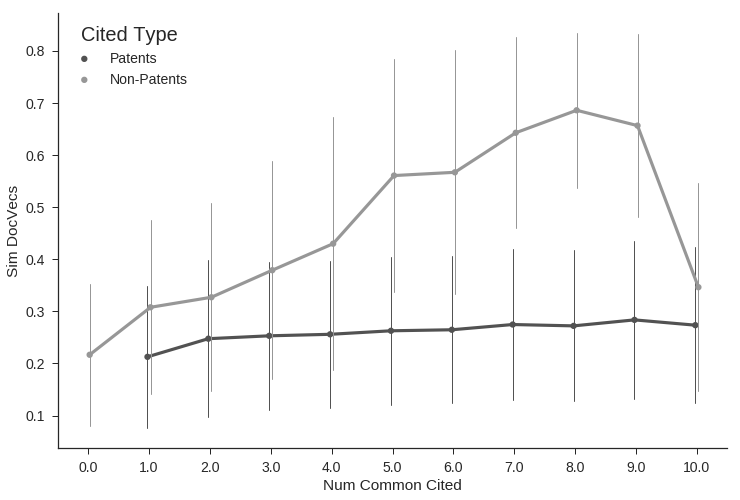

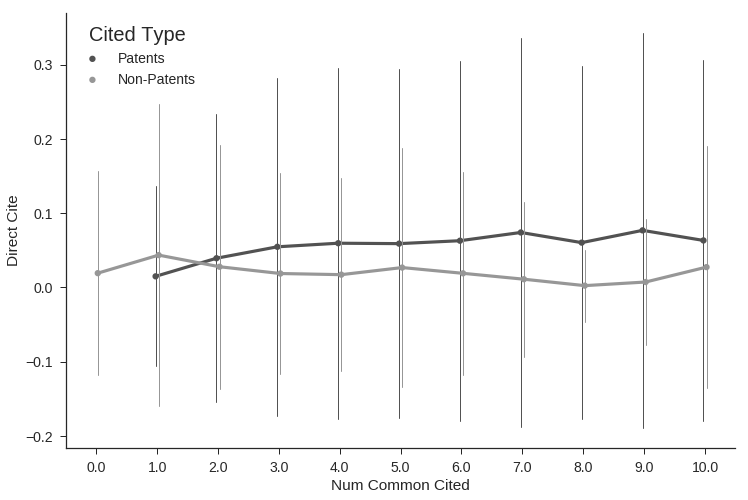

In [59]:
x1 = "common_cited"
y1 = "sim_docvecs"
hue1 = "Cited Type"
df = m2
order1 = None
conf_int1 = "sd"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = hue1)
# ax.set_xticklabels(c_dict["x_labels"][x1])
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"5-MDC-NPC-DV.png")
plt.show()
del(fig, ax)

x1 = "common_cited"
y1 = "op_cites_tp"
hue1 = "Cited Type"
df = m2
order1 = None
conf_int1 = "sd"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = hue1)
# ax.set_xticklabels(c_dict["x_labels"][x1])
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"5-MDC-NPC-DC.png")
plt.show()
del(fig, ax)

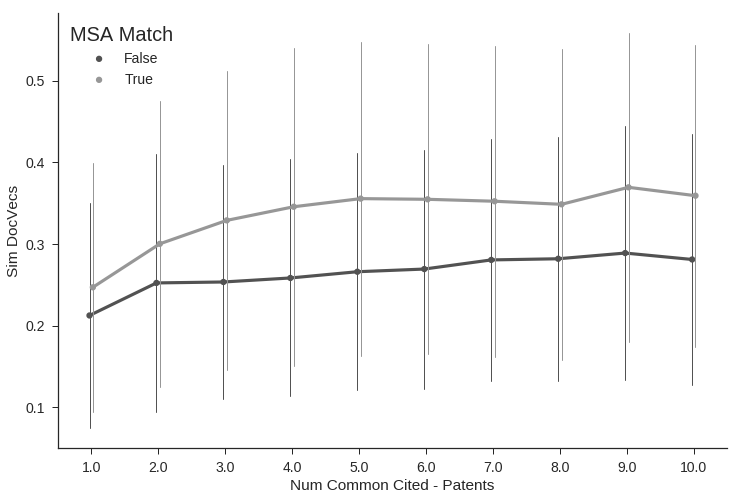

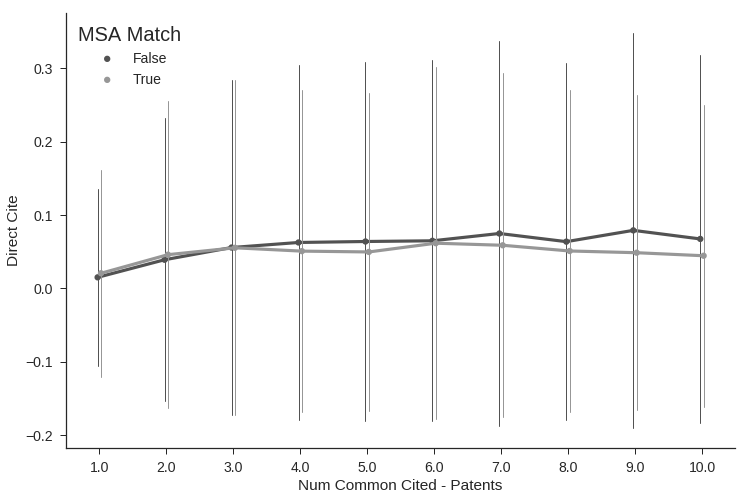

In [63]:
x1 = "num_common_cited"
y1 = "sim_docvecs"
hue1 = "inv_msa_match"
df = mdc.loc[mdc[x1] <= 10]
order1 = None
conf_int1 = "sd"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])
# ax.set_xticklabels(c_dict["x_labels"][x1])
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"5-MDC-PC-LocalDV.png")
plt.show()
del(fig, ax)

x1 = "num_common_cited"
y1 = "op_cites_tp"
hue1 = "inv_msa_match"
df = mdc.loc[mdc[x1] <= 10]
order1 = None
conf_int1 = "sd"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])
# ax.set_xticklabels(c_dict["x_labels"][x1])
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"5-MDC-PC-LocalDC.png")
plt.show()
del(fig, ax)

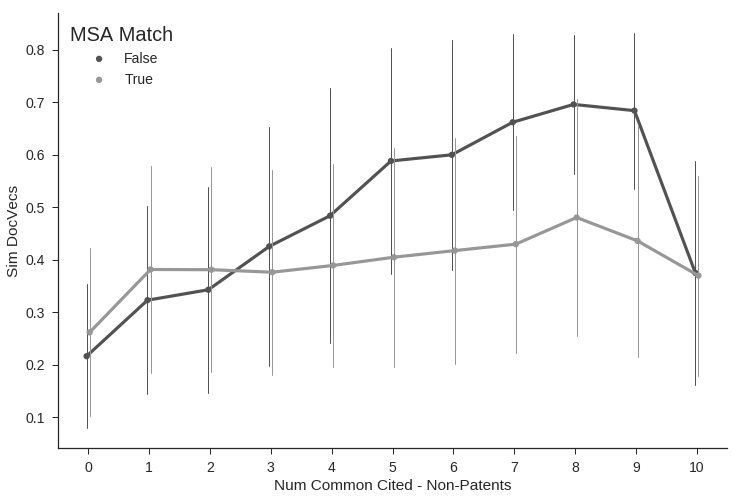

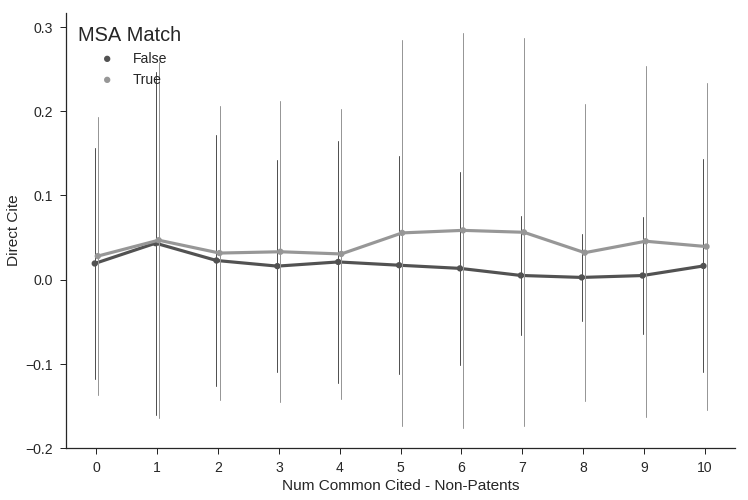

In [62]:
x1 = "num_common_npc"
y1 = "sim_docvecs"
hue1 = "inv_msa_match"
df = mdc.loc[mdc[x1] <= 10]
order1 = None
conf_int1 = "sd"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])
# ax.set_xticklabels(c_dict["x_labels"][x1])
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"5-MDC-NPC-LocalDV.png")
plt.show()
del(fig, ax)

x1 = "num_common_npc"
y1 = "op_cites_tp"
hue1 = "inv_msa_match"
df = mdc.loc[mdc[x1] <= 10]
order1 = None
conf_int1 = "sd"
fig, ax = plt.subplots(figsize=(12,8))
g3 = p1(x = x1, y = y1, order = order1, data = df, bars = conf_int1, hue = hue1, ax = ax)
g3.legend(loc='upper left', title = c_dict[hue1])
# ax.set_xticklabels(c_dict["x_labels"][x1])
ax.set_xlabel(c_dict[x1])
ax.set_ylabel(c_dict[y1])
plt.savefig(savepath+"5-MDC-NPC-LocalDC.png")
plt.show()
del(fig, ax)

### Adenovirus patents
- tp 5585362 ("Philadelphia-Camden-Wilmington, PA-NJ-DE-MD"), op 5651964 ("Houston-Sugar Land-Baytown, TX")
- Compare to: 5643782 ("Philadelphia")

In [24]:
# sim = fastparquet.ParquetFile("DataStore/2018-08/newterms_pats_sim_cite_0903.parq").to_pandas()
sim = sim.loc[(sim["sim_docvecs"]>= 0.3) & (sim["tp_term"] == "adenovir")]

In [30]:
sim.loc[sim["tp"] == 5585362]

,sim_ldavecs,tp,op,sim_docvecs,tp_term,tp_firstyear,tp_gyear,tp_inv_msa,tp_primclass,tp_naics_name,...,op_appdate,inv_msa_match,direct_cite,num_common_cites,tp_num_cites,op_num_cites,tp_num_cites_inv_msa,op_num_cites_inv_msa,tp_pct_cite_msa_match,op_pct_cite_msa_match
index,,,,,,,,,,,,,,,,,,,,,
60,0.674820,5585362,5618714,0.377888,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-12-15,False,False,0,7,3,0,0,0.0,0.000000
63,0.668252,5585362,5643782,0.317765,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-08-23,False,False,0,7,2,0,0,0.0,0.000000
64,0.878897,5585362,5651964,0.326373,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-12-04,False,False,0,7,1,0,0,0.0,0.000000
66,0.821260,5585362,6410010,0.370980,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-10-29,False,True,0,7,12,0,1,0.0,0.083333
67,0.762562,5585362,6682728,0.380365,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-10-13,False,False,0,7,2,0,0,0.0,0.000000
68,0.907133,5585362,6686200,0.308543,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-08-31,False,False,0,7,5,0,0,0.0,0.000000


In [27]:
sim.loc[sim["op_inv_msa"]=="Houston-Sugar Land-Baytown, TX"]

,sim_ldavecs,tp,op,sim_docvecs,tp_term,tp_firstyear,tp_gyear,tp_inv_msa,tp_primclass,tp_naics_name,...,op_appdate,inv_msa_match,direct_cite,num_common_cites,tp_num_cites,op_num_cites,tp_num_cites_inv_msa,op_num_cites_inv_msa,tp_pct_cite_msa_match,op_pct_cite_msa_match
index,,,,,,,,,,,,,,,,,,,,,
42,0.705852,5543328,5631236,0.316034,adenovir,1993,1996.0,"Washington-Arlington-Alexandria, DC-VA-MD-WV",435.0,Pharmaceutical and Medicines,...,1993-08-26,False,False,0,0,0,0,0,NaN,NaN
45,0.756707,5543328,5651964,0.348530,adenovir,1993,1996.0,"Washington-Arlington-Alexandria, DC-VA-MD-WV",435.0,Pharmaceutical and Medicines,...,1993-12-04,False,False,0,0,1,0,0,NaN,0.000000
64,0.878897,5585362,5651964,0.326373,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-12-04,False,False,0,7,1,0,0,0.0,0.000000
66,0.821260,5585362,6410010,0.370980,adenovir,1993,1996.0,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",514.0,Other Chemical Product and Preparation,...,1993-10-29,False,True,0,7,12,0,1,0.0,0.083333
69,0.634876,5618714,5631236,0.507737,adenovir,1993,NaN,None,NaN,None,...,1993-08-26,False,False,0,3,0,0,0,0.0,NaN
70,0.696586,5618714,5641484,0.406348,adenovir,1993,NaN,None,NaN,None,...,1993-12-04,False,False,0,3,1,0,0,0.0,0.000000
72,0.718794,5618714,5651964,0.381991,adenovir,1993,NaN,None,NaN,None,...,1993-12-04,False,False,0,3,1,0,0,0.0,0.000000
74,0.712875,5618714,6410010,0.410244,adenovir,1993,NaN,None,NaN,None,...,1993-10-29,False,False,0,3,12,0,1,0.0,0.083333
85,0.981522,5641484,5651964,0.673056,adenovir,1993,1997.0,"Houston-Sugar Land-Baytown, TX",424.0,Pharmaceutical and Medicines,...,1993-12-04,True,False,1,1,1,0,0,0.0,0.000000


### Sim PC & Sim PC MSA Examples

In [38]:
# ps = fastparquet.ParquetFile("DataStore/2018-10/Reg0930/primclass_all_1004.parq").to_pandas()
ps["op"] = ps["op"].astype(int)

In [40]:
ps2 = ps.loc[ps["norm_mean_sim_docvecs_pc_msa"] >= 2.5]

# What primary class?
display(ps2["tp_primclass"].value_counts().head(10))
pc_count = ps2["tp_primclass"].value_counts()/len(ps2)
display(pc_count.head(10))

# What city?
display(ps2["tp_inv_msa"].value_counts().head(10))

# What year groups?
display(ps2["year_group"].value_counts().head(10))

# What PC, MSA?
display(ps2[["tp", "tp_primclass", "tp_inv_msa", "op_primclass", "op_inv_msa"]]\
        .groupby(["tp_primclass", "tp_inv_msa", "op_primclass", "op_inv_msa"]).size()\
        .sort_values(ascending=False).head(10))

# Highest similarities
s = ps2[["norm_sim_docvecs", "tp_primclass", "tp_inv_msa", "op_primclass", "op_inv_msa"]]\
        .groupby(["tp_primclass", "tp_inv_msa", "op_primclass", "op_inv_msa"]).mean()
m = ps2[["norm_sim_docvecs", "tp_primclass", "tp_inv_msa", "op_primclass", "op_inv_msa"]]\
        .groupby(["tp_primclass", "tp_inv_msa", "op_primclass", "op_inv_msa"]).size()
s = pd.concat([s,m], axis=1).sort_values(by="norm_sim_docvecs",ascending=False)

514.0    9232
800.0     728
546.0     483
544.0     422
475.0     349
424.0     348
297.0     309
548.0     277
524.0     270
435.0     259
Name: tp_primclass, dtype: int64

514.0    0.294247
800.0    0.023203
546.0    0.015394
544.0    0.013450
475.0    0.011124
424.0    0.011092
297.0    0.009849
548.0    0.008829
524.0    0.008606
435.0    0.008255
Name: tp_primclass, dtype: float64

New York-Northern New Jersey-Long Island, NY-NJ-PA    2189
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD           1898
Boston-Cambridge-Quincy, MA-NH                        1249
San Francisco-Oakland-Fremont, CA                     1196
Chicago-Joliet-Naperville, IL-IN-WI                    868
San Diego-Carlsbad-San Marcos, CA                      775
Indianapolis-Carmel, IN                                758
Detroit-Warren-Livonia, MI                             731
San Jose-Sunnyvale-Santa Clara, CA                     683
Ann Arbor, MI                                          572
Name: tp_inv_msa, dtype: int64

2005-15    13944
1995-05     8574
1985-95     6271
1975-85     2586
Name: year_group, dtype: int64

tp_primclass  tp_inv_msa                                          op_primclass  op_inv_msa                                        
514.0         Philadelphia-Camden-Wilmington, PA-NJ-DE-MD         514.0         Philadelphia-Camden-Wilmington, PA-NJ-DE-MD           659
              New York-Northern New Jersey-Long Island, NY-NJ-PA  514.0         New York-Northern New Jersey-Long Island, NY-NJ-PA    588
              Boston-Cambridge-Quincy, MA-NH                      514.0         Boston-Cambridge-Quincy, MA-NH                        329
              San Francisco-Oakland-Fremont, CA                   514.0         San Francisco-Oakland-Fremont, CA                     310
              Chicago-Joliet-Naperville, IL-IN-WI                 514.0         Chicago-Joliet-Naperville, IL-IN-WI                   172
475.0         Detroit-Warren-Livonia, MI                          475.0         Detroit-Warren-Livonia, MI                            164
514.0         New York-Northern New Jerse

In [33]:
ps3 = ps2.loc[(ps2["tp_primclass"] == 514) & \
        (ps2["tp_inv_msa"] == "New York-Northern New Jersey-Long Island, NY-NJ-PA")]
print(ps3.loc[ps3["inv_msa_match"] == True, "norm_sim_docvecs"].mean(),
      ps3.loc[ps3["inv_msa_match"] == False, "norm_sim_docvecs"].mean())
ps3 = ps2.loc[(ps2["tp_primclass"] == 514) & \
        (ps2["tp_inv_msa"] == "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD")]
print(ps3.loc[ps3["inv_msa_match"] == True, ["norm_sim_docvecs", "norm_mean_sim_docvecs_pc_msa"]].mean(),
      ps3.loc[ps3["op_inv_msa"] == "New York-Northern New Jersey-Long Island, NY-NJ-PA",
              ["norm_sim_docvecs", "norm_mean_sim_docvecs_pc_msa"]].mean())

1.2348848426392973 1.2313545937288242
norm_sim_docvecs                1.136051
norm_mean_sim_docvecs_pc_msa    2.889403
dtype: float64 norm_sim_docvecs                1.344366
norm_mean_sim_docvecs_pc_msa    2.861914
dtype: float64


## NYC & Philadelphia patents from 514
Index: 28452

In [42]:
ps2.loc[28452, ["tp", "op"]]

tp    7723345
op    7820722
Name: 28452, dtype: object

In [35]:
ps2.loc[(ps2["tp_inv_msa"] == "New York-Northern New Jersey-Long Island, NY-NJ-PA")
       & (ps2["op_inv_msa"] == "Philadelphia-Camden-Wilmington, PA-NJ-DE-MD")]

,tp,op,sim_docvecs,sim_ldavecs,tp_gyear,tp_naics_name,tp_primclass,tp_inv_msa,op_naics_name,op_primclass,...,norm_mean_sim_docvecs_pc,norm_mean_sim_ldavecs_pc,norm_mean_sim_docvecs_pc_msa,norm_mean_sim_ldavecs_pc_msa,sd_sim_docvecs_pc,sd_sim_ldavecs_pc,sd_sim_docvecs_pc_msa,sd_sim_ldavecs_pc_msa,pc_msa_greater_0,pc_msa_less_0
index,,,,,,,,,,,,,,,,,,,,,
15607,7276529,7345035.0,0.575815,0.899350,2007,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,5.286952,3.424395,2.851796,1.766692,0.220697,0.268733,0.244944,0.285134,1,0
28452,7723345,7820722.0,0.715663,0.688757,2010,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,5.339962,3.640330,3.246917,2.230417,0.217170,0.269799,0.227465,0.256920,1,0
37406,7015190,7544677.0,0.112707,0.896303,2006,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,4.789219,3.249540,2.937851,1.667485,0.220254,0.274968,0.240150,0.285233,1,0
52531,6858608,7001901.0,0.561167,0.925144,2005,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,4.939285,3.067427,2.826770,1.600869,0.216476,0.281709,0.235901,0.289113,1,0
59830,6914057,6939896.0,0.151499,0.587854,2005,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,4.939285,3.067427,2.826770,1.600869,0.216476,0.281709,0.235901,0.289113,1,0
75756,7202270,7338963.0,0.579978,0.557073,2007,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,5.286952,3.424395,2.851796,1.766692,0.220697,0.268733,0.244944,0.285134,1,0
77547,7772276,8193168.0,0.229387,0.454879,2010,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,5.339962,3.640330,3.246917,2.230417,0.217170,0.269799,0.227465,0.256920,1,0
82560,5985930,6008254.0,0.224780,0.764512,1999,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,4.138285,2.822841,2.620218,1.538983,0.209549,0.280043,0.220772,0.293280,1,0
85598,7084154,7153882.0,0.152688,0.384510,2006,Other Chemical Product and Preparation,514.0,"New York-Northern New Jersey-Long Island, NY-N...",Other Chemical Product and Preparation,514.0,...,4.789219,3.249540,2.937851,1.667485,0.220254,0.274968,0.240150,0.285233,1,0
